# Clase 01: Conceptos básicos de NLP

Instalar y cargar las librerías como sigue a continuación: 

In [1]:
# si no tiene alguna librería, ejecutar en un bloque lo siguiente:
# !pip install -U nombre_libreria

import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
from tqdm.auto import tqdm
import csv
import os
import emoji
import matplotlib.pyplot as plt

c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

Usaremos un dataset de mensajes de odio en español alojado en <https://zenodo.org/record/2592149#.Ystdn3bMKUl>

In [2]:
cwd = os.getcwd()
print(os.path.join(cwd, "labeled_corpus_6K.txt"))

d:\dev\MTI-455\notebooks\labeled_corpus_6K.txt


In [133]:
df = pd.read_csv(os.path.join(cwd, "labeled_corpus_6K.txt"),
                         sep = "\t", 
                         encoding = "utf8",
                         quotechar = "\"",
                         names=['id', 'text', 'class'], 
                         header=None) 

In [134]:
df.head(5)

,id,text,class
0,828025263321657348,Ismael es egocentrico porque se vuelve loca si...,0
1,828025128797741057,..ya tardaba en salir quien pronunciase nombre...,0
2,828025087815274496,"(Esto no es un discurso político y razonado, o...",0
3,828025006626058241,"Muy despreciados,siiii,pero todos vestidos de ...",1
4,828024709761658880,marica explicame porque a veces no te entiendo...,1


# Pre-procesamos el texto

Utilizaremos un archivo llamado ``preprocessing_tweets.py`` que contiene diversas funciones para limpiar el texto.



In [135]:
# todo a minúscula.
from preprocessing_tweets import *
df['text_prepro'] = df['text'].str.lower()

In [136]:
df.head()

,id,text,class,text_prepro
0,828025263321657348,Ismael es egocentrico porque se vuelve loca si...,0,ismael es egocentrico porque se vuelve loca si...
1,828025128797741057,..ya tardaba en salir quien pronunciase nombre...,0,..ya tardaba en salir quien pronunciase nombre...
2,828025087815274496,"(Esto no es un discurso político y razonado, o...",0,"(esto no es un discurso político y razonado, o..."
3,828025006626058241,"Muy despreciados,siiii,pero todos vestidos de ...",1,"muy despreciados,siiii,pero todos vestidos de ..."
4,828024709761658880,marica explicame porque a veces no te entiendo...,1,marica explicame porque a veces no te entiendo...


Eliminamos menciones de URL

In [137]:
# eliminamos urls
tqdm.pandas()
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_mentions_urls(text))

100%|██████████| 5938/5938 [00:00<00:00, 296910.90it/s]


In [138]:
# eliminamos hashtags
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_hts(text))

100%|██████████| 5938/5938 [00:00<00:00, 349324.34it/s]


In [139]:
# eliminamos puntuacion
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_punctuation(text))

100%|██████████| 5938/5938 [00:00<00:00, 116435.46it/s]


In [140]:
# eliminamos numeros
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_numbers(text))

100%|██████████| 5938/5938 [00:00<00:00, 296917.98it/s]


In [141]:
# eliminamos tildes
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_accents(text))

100%|██████████| 5938/5938 [00:00<00:00, 742193.20it/s]


In [142]:
# eliminamos stopwords
stopwords = create_stopwords()
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_stopwords(text, stopwords))

100%|██████████| 5938/5938 [00:00<00:00, 312560.74it/s]


In [143]:
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_dots(text))

100%|██████████| 5938/5938 [00:00<00:00, 742259.56it/s]


In [144]:
df.head()

,id,text,class,text_prepro
0,828025263321657348,Ismael es egocentrico porque se vuelve loca si...,0,ismael egocentrico vuelve loca pelo bonito😂😂😂😂...
1,828025128797741057,..ya tardaba en salir quien pronunciase nombre...,0,tardaba salir pronunciase nombre catalan silab...
2,828025087815274496,"(Esto no es un discurso político y razonado, o...",0,discurso politico razonado obviamente llamada ...
3,828025006626058241,"Muy despreciados,siiii,pero todos vestidos de ...",1,despreciados siiii vestidos alta costura españ...
4,828024709761658880,marica explicame porque a veces no te entiendo...,1,marica explicame entiendo — venir ensuciar cc ...


# Tokenizar el texto

In [145]:
df['tokenized_text'] = df.progress_apply(lambda row: nltk.word_tokenize(row['text_prepro']), axis=1)

100%|██████████| 5938/5938 [00:00<00:00, 12633.32it/s]


In [146]:
df.head()

,id,text,class,text_prepro,tokenized_text
0,828025263321657348,Ismael es egocentrico porque se vuelve loca si...,0,ismael egocentrico vuelve loca pelo bonito😂😂😂😂...,"[ismael, egocentrico, vuelve, loca, pelo, boni..."
1,828025128797741057,..ya tardaba en salir quien pronunciase nombre...,0,tardaba salir pronunciase nombre catalan silab...,"[tardaba, salir, pronunciase, nombre, catalan,..."
2,828025087815274496,"(Esto no es un discurso político y razonado, o...",0,discurso politico razonado obviamente llamada ...,"[discurso, politico, razonado, obviamente, lla..."
3,828025006626058241,"Muy despreciados,siiii,pero todos vestidos de ...",1,despreciados siiii vestidos alta costura españ...,"[despreciados, siiii, vestidos, alta, costura,..."
4,828024709761658880,marica explicame porque a veces no te entiendo...,1,marica explicame entiendo — venir ensuciar cc ...,"[marica, explicame, entiendo, —, venir, ensuci..."


In [147]:
df.iloc[0]['tokenized_text']

['ismael',
 'egocentrico',
 'vuelve',
 'loca',
 'pelo',
 'bonito😂😂😂😂',
 'define',
 'objetivo']

## Vectorizar y crear matrices en base a frecuencia de los término en cada documento

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
vect = CountVectorizer()  
vects = vect.fit_transform(df.text_prepro)

In [20]:
vects

<5938x12916 sparse matrix of type '<class 'numpy.int64'>'
	with 41466 stored elements in Compressed Sparse Row format>

In [47]:
td.shape

(5938, 12916)

In [44]:
# transformamos nuestra matriz sparse a un dataframe
td = pd.DataFrame(vects.todense())
# cada columna es renombrada con el termino del vocabulario
td.columns = vect.get_feature_names()
# transponemos la matriz para generar una de termino-documento
term_document_matrix = td.T
# cada columna, que ahora es un documento, se le da un nombre generico
term_document_matrix.columns = ['Doc'+str(i) for i in range(1, td.shape[0]+1)]
# estimamos la suma de cada termino en todos los documentos y la agregamos como una columna
term_document_matrix['total_count'] = term_document_matrix.sum(axis=1)

# Top 25 words 
term_document_matrix = term_document_matrix.sort_values(by ='total_count',ascending=False)

# Print the first 10 rows 
print(term_document_matrix.head(10))

c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


                 Doc1  Doc2  Doc3  Doc4  Doc5  Doc6  Doc7  Doc8  Doc9  Doc10  \
subnormal           0     0     0     0     0     0     0     0     0      0   
independentista     0     0     0     0     0     0     0     0     0      0   
fascista            0     0     0     0     0     0     0     0     0      0   
facha               0     0     0     0     0     0     0     0     0      0   
mierda              0     0     0     0     0     0     0     0     0      0   
fascistas           0     0     0     0     0     0     0     0     0      0   
fachas              0     0     0     0     0     0     0     0     0      0   
puta                0     0     0     0     0     0     0     0     0      0   
puto                0     0     0     0     0     0     0     0     0      0   
maricon             0     0     0     0     0     0     0     0     1      0   

                 ...  Doc5930  Doc5931  Doc5932  Doc5933  Doc5934  Doc5935  \
subnormal        ...        0        0   

<AxesSubplot:>

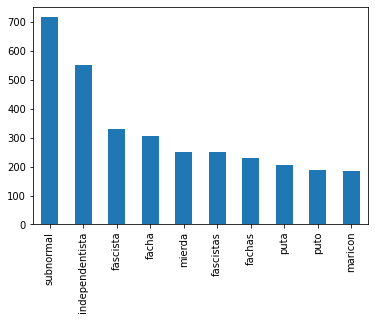

In [22]:
# graficamos los top 10 palabras de acuerdo a su frecuencia
term_document_matrix['total_count'].head(10).plot.bar()


## Vectorizar y crear matrices en base a TF-IDF de los términos en cada documento

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
tfidf_vectorizer = TfidfVectorizer()
vects_tfidf = tfidf_vectorizer.fit_transform(df.text_prepro)


In [35]:
# transformamos nuestra matriz sparse a un dataframe
td_tfidf = pd.DataFrame(vects_tfidf.todense())
# cada columna es renombrada con el termino del vocabulario
td_tfidf.columns = tfidf_vectorizer.get_feature_names_out()
# transponemos la matriz para generar una de termino-documento
term_document_matrix_tfidf = td_tfidf.T
# cada columna, que ahora es un documento, se le da un nombre generico
term_document_matrix_tfidf.columns = ['Doc'+str(i) for i in range(1, td_tfidf.shape[0]+1)]
# estimamos la suma de cada termino en todos los documentos y la agregamos como una columna
term_document_matrix_tfidf['total_count'] = term_document_matrix_tfidf.sum(axis=1)

# Top 25 words 
term_document_matrix_tfidf = term_document_matrix_tfidf.sort_values(by ='total_count',ascending=False)

# Print the first 10 rows 
print(term_document_matrix_tfidf.head(10))

                 Doc1  Doc2  Doc3  Doc4  Doc5  Doc6  Doc7  Doc8      Doc9  \
subnormal         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
independentista   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
facha             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
fascista          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
mierda            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
fascistas         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
fachas            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
maricon           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.397998   
puto              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
puta              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   

                 Doc10  ...   Doc5930   Doc5931   Doc5932   Doc5933  Doc5934  \
subnormal          0.0  ...  0.000000  0.000000  0.000000  0.000000  0.0

<AxesSubplot:>

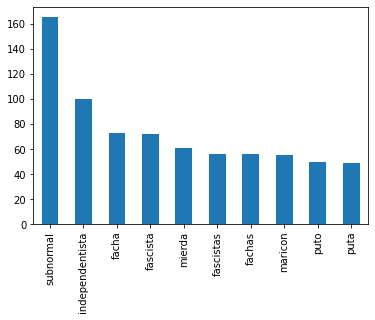

In [37]:
# graficamos los top 10 palabras de acuerdo a su frecuencia
term_document_matrix_tfidf['total_count'].head(10).plot.bar()

# Similitud entre documentos (vectores)

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
cosine_similarities = cosine_similarity(term_document_matrix.T)

In [54]:
cosine_similarities[0]

array([1.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.04397717])

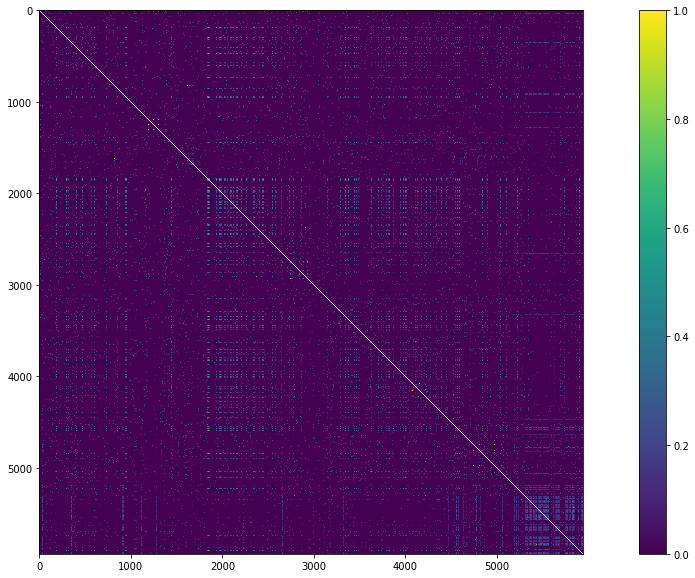

In [68]:
plt.figure(figsize = (20,10))
plt.imshow(cosine_similarities, interpolation='none')
plt.colorbar()
plt.show()

In [69]:
def argsort_sim_mat(sm):
    idx = [np.argmax(np.sum(sm, axis=1))]  # a
    for i in range(1, len(sm)):
        sm_i = sm[idx[-1]].copy()
        sm_i[idx] = -1
        idx.append(np.argmax(sm_i))  # b
    return np.array(idx)

In [70]:
idx = argsort_sim_mat(cosine_similarities)
sim_mat2 = cosine_similarities[idx, :][:, idx]  # apply reordering for rows and columns

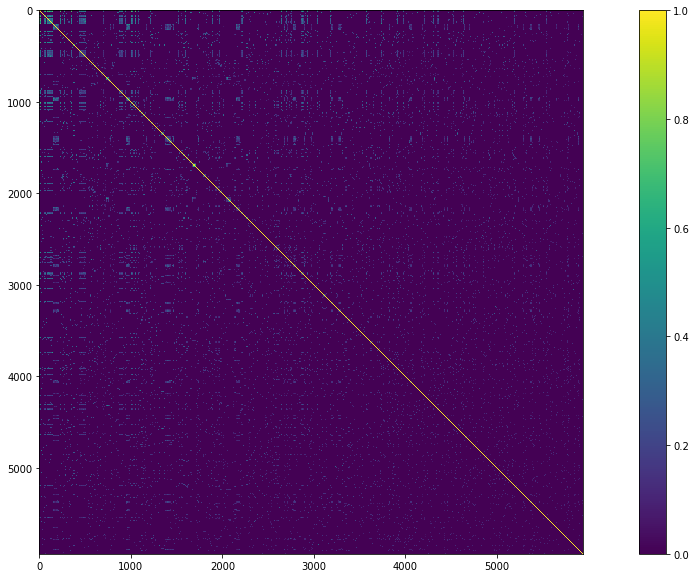

In [71]:
plt.figure(figsize = (20,10))
plt.imshow(sim_mat2, interpolation='none')
plt.colorbar()
plt.show()

In [65]:
cosine_similarities_tfidf = cosine_similarity(term_document_matrix_tfidf.T)

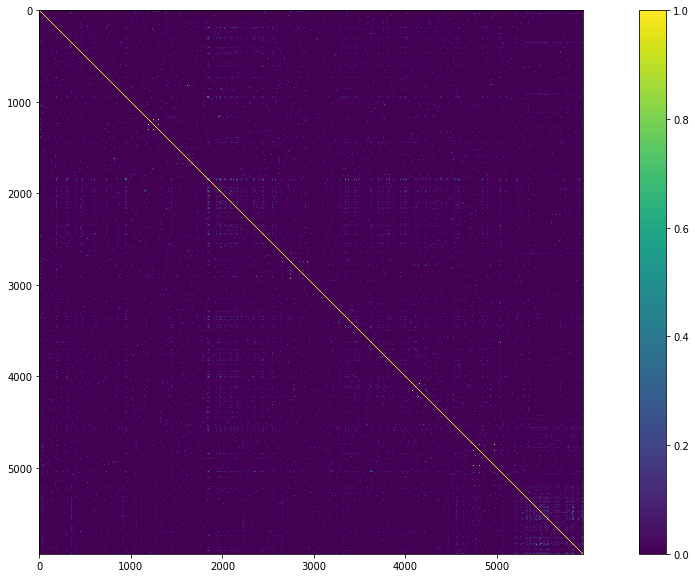

In [66]:
plt.figure(figsize = (20,10))
plt.imshow(cosine_similarities_tfidf, interpolation='none')
plt.colorbar()
plt.show()

# Topic modelling

Utilizaremos el algoritmo Latent Dirichlet Allocation (LDA) para encontrar tópicos a partir de un conjunto de documentos

In [73]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [77]:
# Creamos un diccionario a partir del texto tokenizado previamente
dic = Dictionary(df['tokenized_text'])
corpus = [dic.doc2bow(text) for text in df['tokenized_text']]

In [98]:
# Estimamos el modelo a partir del corpus y diccionario, con número de tópicos igual a ntop
ntop = 5
lda = LdaModel(corpus=corpus, id2word=dic, iterations=100, num_topics=ntop)

In [99]:
# mostramos los terminos que componen cada topico
lda.show_topics(num_topics=5, num_words = 5, formatted=False)

[(0,
  [('independentista', 0.017850151),
   ('facha', 0.011418594),
   ('mayoria', 0.009562367),
   ('subnormal', 0.009242059),
   ('gay', 0.0067698844)]),
 (1,
  [('subnormal', 0.031515125),
   ('gente', 0.007875737),
   ('fachas', 0.0053062313),
   ('fascista', 0.004324996),
   ('dictador', 0.0040372666)]),
 (2,
  [('votos', 0.010330332),
   ('subnormal', 0.0095557375),
   ('independentista', 0.0077778003),
   ('cataluña', 0.006855615),
   ('fascistas', 0.0066482476)]),
 (3,
  [('independentista', 0.041100048),
   ('mayoria', 0.010602493),
   ('fascista', 0.008783488),
   ('fachas', 0.00872974),
   ('subnormal', 0.0070140054)]),
 (4,
  [('maricon', 0.009517515),
   ('cataluña', 0.008686671),
   ('mierda', 0.006669243),
   ('facha', 0.0064234426),
   ('fascista', 0.0053213094)])]

## Para cada documento, estimamos cual topico lo representa de mejor forma

In [93]:
def format_topics_sentences(ldamodel, cor, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[cor]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda, corpus, df['tokenized_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_9504\4083079659.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_9504\4083079659.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.7985,"independentista, subnormal, fascista, cataluña...","[ismael, egocentrico, vuelve, loca, pelo, boni..."
1,1,0,0.9381,"fascista, subnormal, independentista, puigdemo...","[tardaba, salir, pronunciase, nombre, catalan,..."
2,2,1,0.7457,"mayoria, facha, independentista, fachas, puto,...","[discurso, politico, razonado, obviamente, lla..."
3,3,0,0.9192,"fascista, subnormal, independentista, puigdemo...","[despreciados, siiii, vestidos, alta, costura,..."
4,4,3,0.7691,"independentista, muerte, dictador, mierda, sub...","[marica, explicame, entiendo, —, venir, ensuci..."
5,5,0,0.9093,"fascista, subnormal, independentista, puigdemo...","[abusan, niñas, años, policia, miedo, llamasen..."
6,6,0,0.9253,"fascista, subnormal, independentista, puigdemo...","[ridiculo, dije, arabe, necesario, comer, culo..."
7,7,3,0.8382,"independentista, muerte, dictador, mierda, sub...","[genero, binario, pronombres, elle]"
8,8,1,0.5516,"mayoria, facha, independentista, fachas, puto,...","[jajajajaja, jodes, maricon]"
9,9,1,0.8836,"mayoria, facha, independentista, fachas, puto,...","[cojones, racistas, blancos, hetero, patriarca..."


## Para cada topico, mostramos la frecuencia de documento que representa

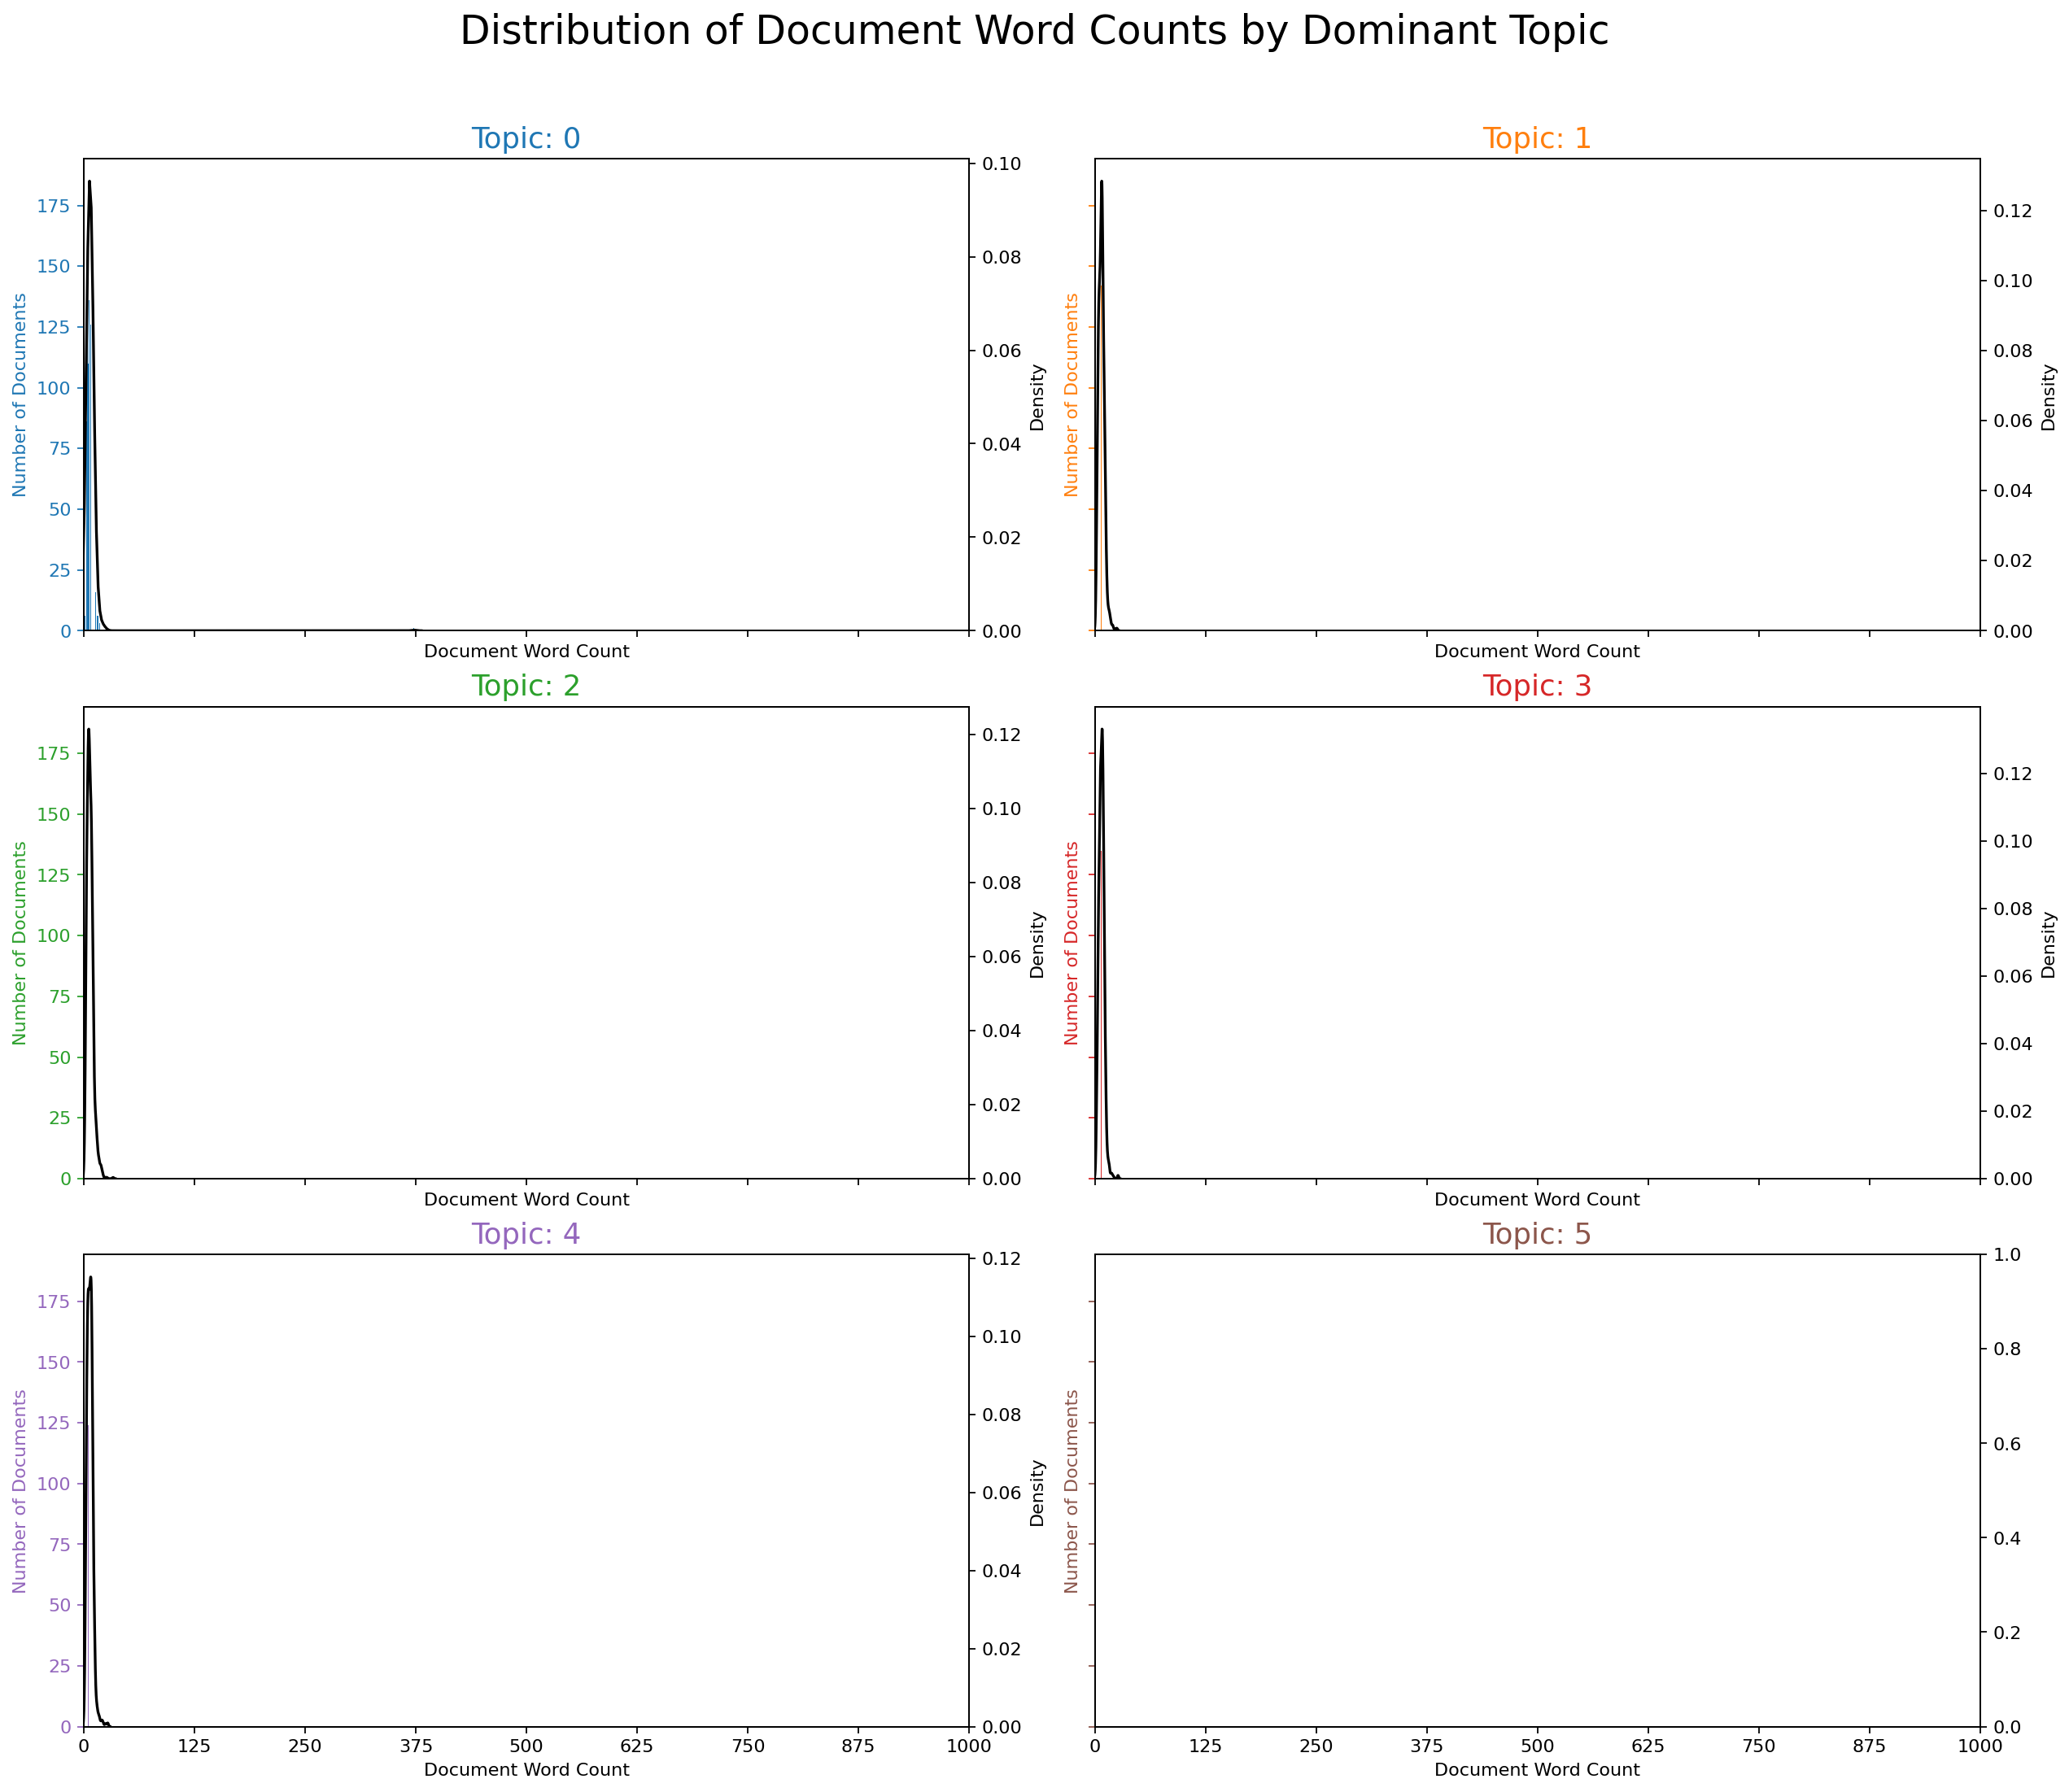

In [97]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_9504\3468274175.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dfout.loc[dfout.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_9504\3468274175.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dfout.loc[dfout.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_9504\3468274175.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dfout.loc[dfout.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


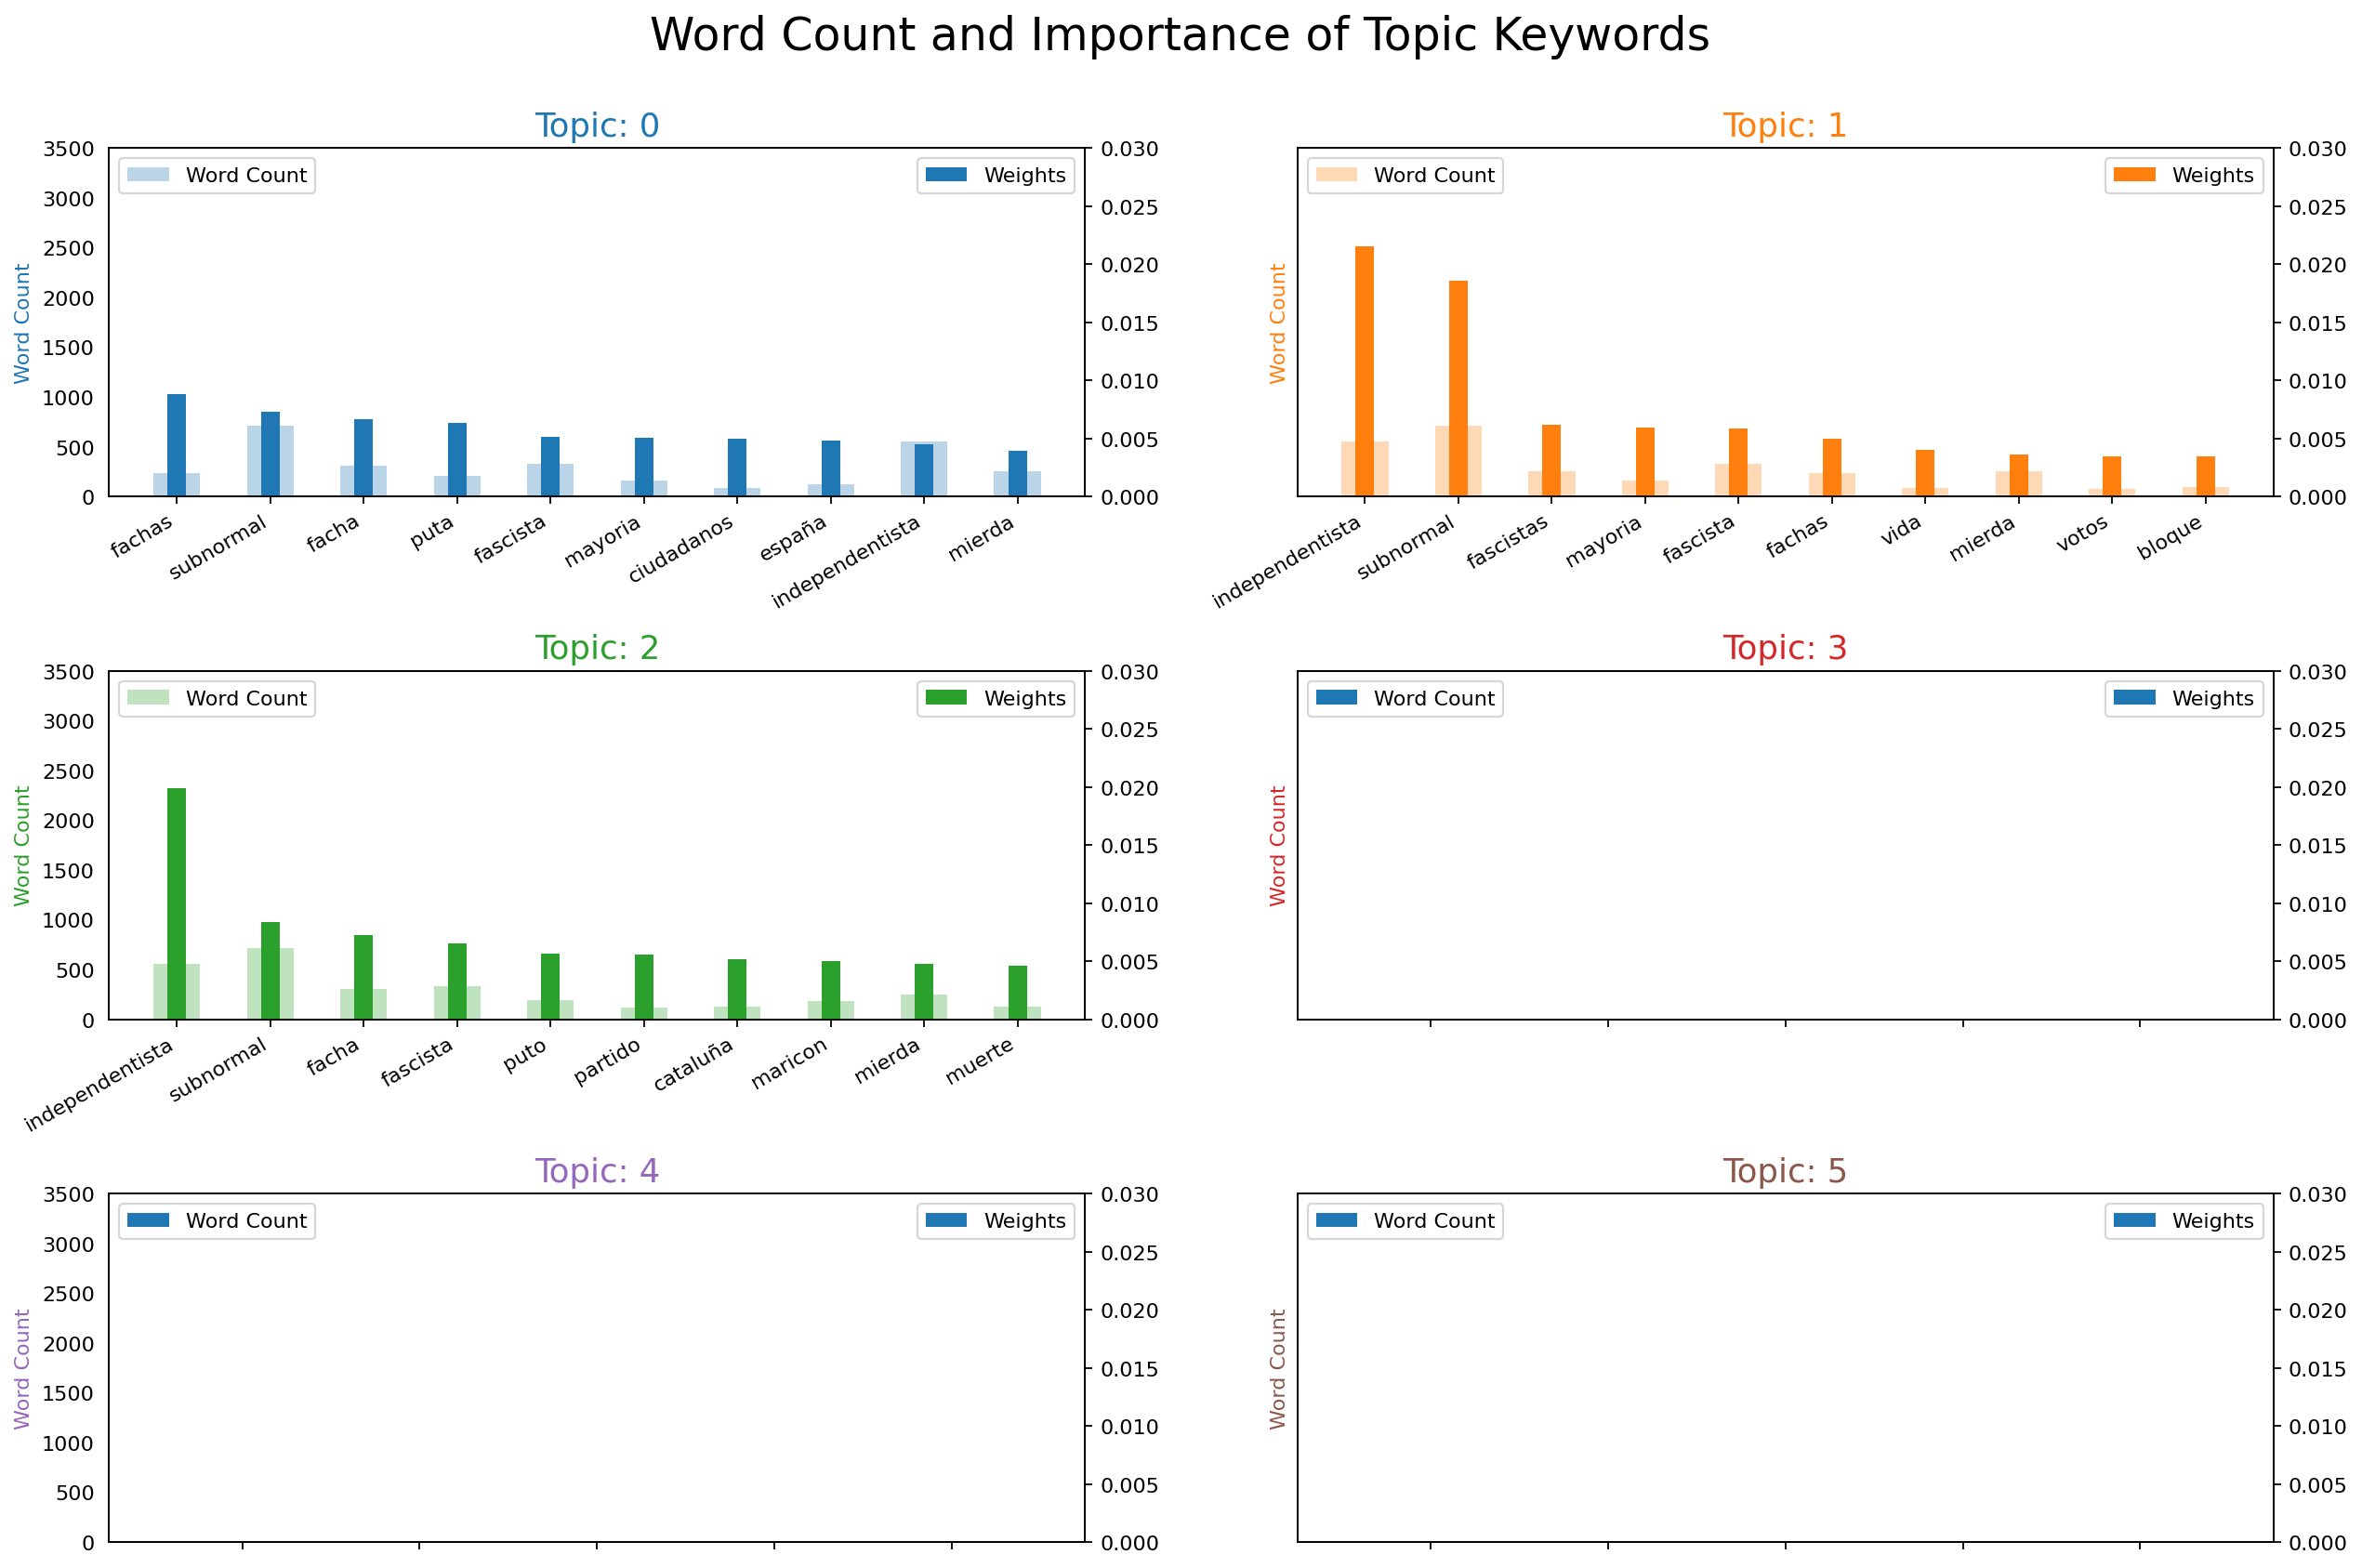

In [148]:
from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in df['tokenized_text'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

dfout = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=dfout.loc[dfout.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=dfout.loc[dfout.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(dfout.loc[dfout.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Estimación de la cantidad de tópicos y términos para LDA

Usaremos una métrica conocida como Coherence, la cual estima el grado de similitud semántica entre palabras con alto puntaje en cada tópico. Es decir, qué tan bien los tópicos se ajustan al texto y que no sean por mera casualidad.

In [120]:
n_topics = range(3,4)
n_terms = range(3,4)
res_lda = []

for to in tqdm(n_topics):
    lda = LdaModel(corpus=corpus, id2word=dic, iterations=100, num_topics=to)
    for te in tqdm(n_terms):
        lda_topics = lda.show_topics(num_topics=to, num_words = te, formatted=False)
        topics = []
        for topic_id, topic in lda_topics:
            topic = [word for word, _ in topic]
            topics.append(topic)
        cm_lda = CoherenceModel(topics=topics, corpus=corpus, dictionary=dic, texts = data_flat,  coherence='c_v')
        res_lda.append((to, te, cm_lda.get_coherence()))

  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
100%|██████████| 1/1 [00:12<00:00, 12.06s/it]


In [128]:
from gensim.models.word2vec import Text8Corpus, LineSentence

In [132]:
df.head()

,word,topic_id,importance,word_count
0,independentista,0,0.017850,552
1,facha,0,0.011419,307
2,mayoria,0,0.009562,164
3,subnormal,0,0.009242,714
4,gay,0,0.006770,131


In [178]:
with open(os.path.join(cwd, "corpus_saved.txt"), 'w', encoding='utf-8') as fp:
    for sentence in df['tokenized_text']:
        fp.write(' '.join(sentence)+'\n')

In [179]:
from gensim.test.utils import datapath
corpus_text = Text8Corpus(datapath(os.path.join(cwd, "corpus_saved.txt")))


In [183]:
dic = Dictionary(corpus_text)
corpus = [dic.doc2bow(text) for text in corpus_text]

In [186]:
lda = LdaModel(corpus=corpus, id2word=dic, iterations=100, num_topics=5)

In [187]:
lda_topics = lda.show_topics(num_topics=5, num_words = 5, formatted=False)
topics = []
for topic_id, topic in lda_topics:
    topic = [word for word, _ in topic]
    topics.append(topic)

In [188]:
cm_lda = CoherenceModel(topics=topics, corpus=corpus, dictionary=dic, texts = corpus_text,  coherence='c_v')
print(cm_lda.get_coherence())

0.42986632841747063


In [121]:
df_results_models = pd.DataFrame(res_lda, columns=['topics', 'terms', 'coherence'])

In [122]:
df_results_models

,topics,terms,coherence
0,3,3,NaN


In [108]:
#import pyLDAvis.gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# Visualize the topics
pyLDAvis.enable_notebook()


In [110]:
gensimvis.prepare(lda, corpus, dic)


c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.138816  0.045369       1        1  21.815322
0     -0.014428  0.008543       2        1  21.594723
2     -0.016964 -0.069458       3        1  20.835497
1      0.066994 -0.100448       4        1  19.099575
4      0.103214  0.115995       5        1  16.654883, topic_info=                 Term        Freq       Total Category  logprob  loglift
141   independentista  680.000000  680.000000  Default  30.0000  30.0000
100         subnormal  509.000000  509.000000  Default  29.0000  29.0000
2266            votos  103.000000  103.000000  Default  28.0000  28.0000
2335          mayoria  212.000000  212.000000  Default  27.0000  27.0000
427          cataluña  148.000000  148.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
27           politico   21.826616  103.272465   Topic5  -5.7967   0.2382
298           aficion   20.212754   79.037437   Topic5  -5.8735   0.4289
141   independentista   35.333586  680.774355   Topic5  -5.3150  -1.1659
411             negro   20.441375  125.407001   Topic5  -5.8623  -0.0215
144            fachas   21.072769  210.970355   Topic5  -5.8319  -0.5113

[365 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4857      2  0.994620  absoluta
5927      3  0.944224       ada
298       1  0.101218   aficion
298       2  0.050609   aficion
298       3  0.240392   aficion
...     ...       ...       ...
228       3  0.062070         »
228       5  0.031035         »
5299      1  0.957294         ‘
5300      1  0.973029         ’
3512      2  0.869531      😂😂😂😂

[616 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 5])